# Quantum Phase Estimation

When constructing circuits for quantum algorithms it is useful to think of higher level operations than just individual quantum gates. In `pytket` we can construct circuits using box structures which abstract away the complexity of the underlying circuit. This notebook is intended to complement the [boxes section](https://tket.quantinuum.com/user-manual/manual_circuit.html#boxes) of the user manual which introduces the different box types.

To demonstrate boxes in `pytket` we will consider the Quantum Phase Estimation algorithm (QPE). This is an important subroutine in several quantum algorithms including Shor's algorithm and fault-tolerant approaches to quantum chemistry.

## Overview of Phase Estimation

The Quantum Phase Estimation algorithm can be used to estimate the eigenvalues of some unitary operator $U$ to some desired precision.

The eigenvalues of $U$ lie on the unit circle, giving us the following eigenvalue equation

$$
\begin{equation}
U |\psi \rangle = e^{2 \pi i \theta} |\psi\rangle\,, \quad 0 \leq \theta \leq 1
\end{equation}
$$

Here $|\psi \rangle$ is an eigenstate of the operator $U$. In phase estimation we estimate the eigenvalue $e^{2 \pi i \theta}$ by approximating $\theta$.


The circuit for Quantum phase estimation is itself composed of several subroutines which we can realise as boxes.

![](images/phase_est.png "Quantum Phase Estimation Circuit")

QPE is generally split up into three stages

1. Firstly we prepare an initial state in one register. In parallel we prepare a uniform superposition state using Hadamard gates on some ancilla (measurement) qubits. The number of ancilla qubits determines how precisely we can estimate the phase $\theta$.

2. Secondly we apply successive controlled $U$ gates. This has the effect of "kicking back" phases onto the ancilla qubits according to the eigenvalue equation above.

3. Finally we apply the inverse Quantum Fourier Transform (QFT). This essentially plays the role of destructive interference, suppressing amplitudes from "undesirable states" and hopefully allowing us to measure a single outcome (or a small number of outcomes) with high probability.


There is some subtlety around the first point. The initial state used can be an exact eigenstate of $U$ however this may be difficult to prepare if we don't know the eigenvalues of  $U$ in advance. Alternatively we could use an initial state that is a linear combination of eigenstates, as the phase estimation will project into the eigenspace of $U$.

We also assume that we can implement $U$ with a quantum circuit. In chemistry applications $U$ could be of the form $U=e^{-iHt}$ where $H$ is the Hamiltonian of some system of interest. In the textbook algorithm, the number of controlled unitaries we apply scales exponentially with the number of measurement qubits. This allows more precision at the expense of a larger quantum circuit.

## The Quantum Fourier Transform

Before considering the other parts of the QPE algorithm, lets focus on the Quantum Fourier Transform (QFT) subroutine.

Mathematically, the QFT has the following action.

$$
\begin{equation}
QFT : |j\rangle\ \longmapsto \frac{1}{\sqrt{N}} \sum_{k=0}^{N - 1} e^{2 \pi ijk/N}|k\rangle, \quad N= 2^n
\end{equation}
$$

This is essentially the Discrete Fourier transform except the input is a quantum state $|j\rangle$.

We can build the circuit for the $n$ qubit QFT using $n$ Hadamard gates $\lfloor{\frac{n}{2}}\rfloor$ swap gates and $\frac{n(n-1)}{2}$ controlled unitary rotations $\text{CU1}$.

$$
 \begin{equation}
U1(\phi) =
 \begin{pmatrix}
 1 & 0 \\
 0 & e^{i \pi \phi}
 \end{pmatrix}\, , \quad
 CU1(\phi) =
 \begin{pmatrix}
 1 & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 \\
 0 & 0 & 1 & 0 \\
 0 & 0 & 0 & e^{i \pi \phi}
 \end{pmatrix}
 \end{equation}
$$

The circuit for the Quantum Fourier transform on three qubits is the following

![](images/qft.png "QFT Circuit")

We can build this circuit in `pytket` by adding gate operations manually:

lets build the QFT for three qubits

In [103]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter

In [142]:
qft3_circ = Circuit(3)
qft3_circ.H(0)
qft3_circ.CU1(0.5, 1, 0)
qft3_circ.CU1(0.25, 2, 0)
qft3_circ.H(1)
qft3_circ.CU1(0.5, 2, 1)
qft3_circ.H(2)
qft3_circ.SWAP(0, 2)
render_circuit_jupyter(qft3_circ)

We can generalise the quantum Fourier transform to $n$ qubits by iterating over the qubits as follows

In [143]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    for i in range(n_qubits):
        circ.H(i)
        for j in range(i + 1, n_qubits):
            circ.CU1(1 / 2 ** (j - i), j, i)
    for k in range(0, n_qubits // 2):
        circ.SWAP(k, n_qubits - k - 1)
    return circ

In [144]:
qft4_circ: Circuit = build_qft_circuit(4)
render_circuit_jupyter(qft4_circ)

Now that we have the generalised circuit we can wrap it up in a `CircBox` which can then be added to another circuit as a subroutine.

In [145]:
from pytket.circuit import CircBox

In [146]:
qft4_box: CircBox = CircBox(qft4_circ)
qft_circ = Circuit(4).add_gate(qft4_box, [0, 1, 2, 3])
render_circuit_jupyter(qft_circ)

Note how the `CircBox` inherits the name `QFT` from the underlying circuit.

Recall that in our phase estimation algorithm we need to use the inverse QFT.

$$
\begin{equation}
\text{QFT}^† : \frac{1}{\sqrt{N}} \sum_{k=0}^{N - 1} e^{2 \pi ijk/N}|k\rangle \longmapsto |j\rangle\,, \quad N= 2^n
\end{equation}
$$


Now that we have the QFT circuit we can obtain the inverse by using `CircBox.dagger`. We can also verify that this is correct by inspecting the circuit inside with `CircBox.get_circuit()`.

In [147]:
inv_qft4_box = qft4_box.dagger
render_circuit_jupyter(inv_qft4_box.get_circuit())

## Building the Phase Estimation Circuit

We can now define a function to build our entire QPE circuit. We can make this function take a state preparation circuit and a unitary circuit as input as well. The function also has the number of measurement qubits as input which will determine the precision of our phase estimate.

In [148]:
from pytket.circuit import QControlBox

In [149]:
def build_phase_estimation_circuit(
    n_measurement_qubits: int, state_prep_circuit: Circuit, unitary_circuit: Circuit
) -> Circuit:
    # Define a Circuit with a measurement and prep register
    qpe_circ: Circuit = Circuit()
    n_state_prep_qubits = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", n_measurement_qubits)
    state_prep_register = qpe_circ.add_q_register("p", n_state_prep_qubits)
    qpe_circ.add_circuit(state_prep_circuit, list(state_prep_register))

    # Create a controlled unitary with a single control qubit
    unitary_circuit.name = "U"
    controlled_u_gate = QControlBox(CircBox(unitary_circuit), 1)

    # Add Hadamard gates to every qubit in the measurement register
    for m_qubit in measurement_register:
        qpe_circ.H(m_qubit)

    # Add all (2**n_measurement_qubits - 1) of the controlled unitaries sequentially
    for m_qubit in range(n_measurement_qubits):
        control_index = n_measurement_qubits - m_qubit - 1
        control_qubit = [measurement_register[control_index]]
        for _ in range(2**m_qubit):
            qpe_circ.add_qcontrolbox(
                controlled_u_gate, control_qubit + list(state_prep_register)
            )

    # Finally, append the inverse qft and measure the qubits
    qft_box = CircBox(build_qft_circuit(n_measurement_qubits))
    inverse_qft_box = qft_box.dagger
    qpe_circ.add_circbox(inverse_qft_box, list(measurement_register))
    qpe_circ.measure_register(measurement_register, "c")
    return qpe_circ

## Phase Estimation with a Trivial Eigenstate

Lets test our circuit construction by preparing a trivial $|1\rangle$ eigenstate of the $\text{U1}$ gate. We can then see if our phase estimation circuit returns the expected eigenvalue.

$$
\begin{equation}
U1(\phi)|1\rangle = e^{i \pi \phi}|1\rangle = e^{2 \pi i \theta} |1\rangle \implies \theta = \frac{\phi}{2}
\end{equation}
$$

So we expect that our ideal phase $\theta$ will be half the input angle $\phi$ to our $U1$ gate.

In [150]:
prep_circuit = Circuit(1).X(0)  # prepare the |1> eigenstate of U1

In [151]:
input_angle = 0.73  # angle as number of half turns

In [152]:
unitary_circuit = Circuit(1).U1(input_angle, 0)  # Base unitary for controlled U ops

In [153]:
qpe_circ_trivial = build_phase_estimation_circuit(
    4, state_prep_circuit=prep_circuit, unitary_circuit=unitary_circuit
)

In [154]:
render_circuit_jupyter(qpe_circ_trivial)

Lets use the noiseless `H1-1LE` simulator to run our phase estimation circuit on Quantinuum Nexus.

In [187]:
from pytket.extensions.nexus import NexusBackend, QuantinuumConfig, Nexus
from datetime import datetime

In [188]:


phase_est_project = Nexus().new_project(f"Phase Estimation Tutorial - {datetime.now()}")

device = "H1-1LE"
# device = "H1-1LE"

configuration = QuantinuumConfig(device_name=device)
# , user_group="iQuHACK_2024"

backend = NexusBackend(
    backend_config= configuration, 
    project= phase_est_project
)


New project created: Phase Estimation Tutorial - 2024-02-04 05:11:03.464594

Started using project with name: Phase Estimation Tutorial - 2024-02-04 05:11:03.464594


In [189]:
from pytket.passes import DecomposeBoxes

DecomposeBoxes().apply(qpe_circ_trivial)


False

In [190]:
compiled_circ = backend.get_compiled_circuit(qpe_circ_trivial)

In [191]:
import time

start = time.time()

n_shots = 1000
result = backend.run_circuit(compiled_circ, n_shots)

end = time.time()

print(end-start)

15.306952476501465


In [192]:
print(result.get_counts())

Counter({(0, 1, 1, 0): 901, (0, 1, 0, 1): 46, (0, 1, 1, 1): 13, (0, 1, 0, 0): 10, (1, 0, 0, 0): 8, (1, 0, 0, 1): 6, (0, 0, 1, 1): 5, (1, 0, 1, 1): 3, (1, 1, 0, 0): 3, (0, 0, 1, 0): 2, (1, 1, 1, 1): 2, (1, 0, 1, 0): 1})


In [193]:
from pytket.backends.backendresult import BackendResult
import matplotlib.pyplot as plt

plotting function for QPE Notebook

In [194]:
def plot_qpe_results(
    sim_result: BackendResult,
    n_strings: int = 10,
    dark_mode: bool = False,
    y_limit: int = 1000,
) -> None:
    """
    Plots results in a barchart given a BackendResult. the number of stings displayed
    can be specified with the n_strings argument.
    """
    counts_dict = sim_result.get_counts()
    sorted_shots = counts_dict.most_common()
    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    if dark_mode:
        plt.style.use("dark_background")
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 0.75, 0.5))
    color_list = ["orange"] * (len(x_axis_values))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Results")
    plt.ylim([0, y_limit])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()

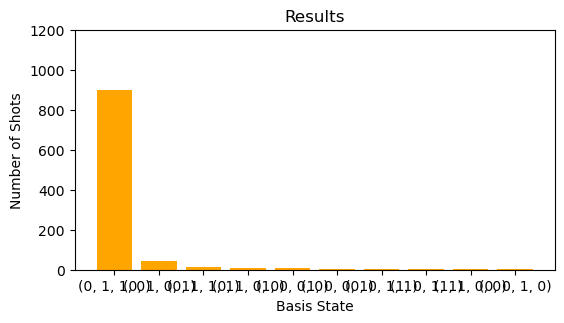

In [195]:
plot_qpe_results(result, y_limit=int(1.2 * n_shots))

As expected we see one outcome with high probability. Lets now extract our approximation of $\theta$ from our output bitstrings.

suppose the $j$ is an integer representation of our most commonly measured bitstring.

$$
\begin{equation}
\theta_{estimate} = \frac{j}{N}
\end{equation}
$$

Here $N = 2 ^m$ where $m$ is the number of measurement qubits.

In [181]:
from pytket.backends.backendresult import BackendResult

In [182]:
def single_phase_from_backendresult(result: BackendResult) -> float:
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0]
    bitstring = "".join([str(bit) for bit in basis_state])
    integer_j = int(bitstring, 2)

    # Calculate theta estimate
    return integer_j / (2 ** len(bitstring))

In [183]:
theta = single_phase_from_backendresult(result)

In [184]:
print(theta)

0.375


In [185]:
print(input_angle / 2)

0.365


Our output is close to half our input angle $\phi$ as expected. Lets calculate our error $E$ to three decimal places.

$$
\begin{equation}
E = |\phi - 2 \, \theta_{estimate}|
\end{equation}
$$

In [186]:
error = round(abs(input_angle - (2 * theta)), 3)
print(error)

0.02


## Phase Estimation with Time Evolution

In the phase estimation algorithm we repeatedly perform controlled unitary operations. In the textbook variant of QPE presented here, the number of controlled unitaries will be $2^m - 1$ where $m$ is the number of measurement qubits.

In the example above we've shown a trivial instance of QPE where we know the exact phase in advance. For more realistic applications of QPE we will have some non-trivial state preparation required.

For chemistry or condensed matter physics $U$ typically be the time evolution operator $U(t) = e^{- i H t}$ where $H$ is the problem Hamiltonian.
Suppose that we had the following decomposition for $H$ in terms of Pauli strings $P_j$ and complex coefficients $\alpha_j$.

$$
\begin{equation}
H = \sum_j \alpha_j P_j\,, \quad \, P_j \in \{I, \,X, \,Y, \,Z\}^{\otimes n}
\end{equation}
$$

Here the term Pauli strings refers to tensor products of Pauli operators. These strings form an orthonormal basis for $2^n \times 2^n$ matrices.

If we have a Hamiltonian in the form above, we can then implement $U(t)$ as a sequence of Pauli gadget circuits. We can do this with the [PauliExpBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.PauliExpBox) construct in pytket. For more on `PauliExpBox` see the [user manual](https://tket.quantinuum.com/user-manual/manual_circuit.html#pauli-exponential-boxes).

Once we have a circuit to implement our time evolution operator $U(t)$, we can construct the controlled $U(t)$ operations using [QControlBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.QControlBox). If our base unitary is a sequence of `PauliExpBox`(es) then there is some structure we can exploit to simplify our circuit. See this [blog post](https://tket.quantinuum.com/blog/posts/controlled_gates/) on [ConjugationBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.ConjugationBox) for more.

As an exercise, try to use phase estimation to calculate the ground state of diatomic hydrogen $H_2$.

## Suggestions for further reading

* Quantinuum paper on Bayesian phase estimation -> https://arxiv.org/pdf/2306.16608.pdf
* Blog post on `ConjugationBox` (efficient circuits for controlled gates) -> https://tket.quantinuum.com/blog/posts/controlled_gates/